<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 9.6: Sentiment Analysis
INSTRUCTIONS:
- Run the cells
- Observe and understand the results
- Answer the questions

Based on the video tutorial **Text Classification with Machine Learning,SpaCy and Scikit(Sentiment Analysis)** by **Jesse E. Agbe (JCharis)**.

## Data Source: UCI
### UCI - Machine Learning Repository
- Center for Machine Learning and Intelligent Systems

The [**UCI Machine Learning Repository**](http://archive.ics.uci.edu/ml/about.html) is a collection of databases, domain theories, and data generators that are used by the machine learning community for the empirical analysis of machine learning algorithms.

### Dataset
- [Sentiment Labelled Sentences Data Set](http://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences)

### Abstract
The dataset contains sentences labelled with positive or negative sentiment.

- Data Set Characteristics: Text
- Number of Instances: 3000
- Area: N/A
- Attribute Characteristics: N/A
- Number of Attributes: N/A
- Date Donated: 2015-05-30
- Associated Tasks: Classification
- Missing Values? N/A
- Number of Web Hits: 102584

### Source
Dimitrios Kotzias dkotzias '@' ics.uci.edu

### Data Set Information
This dataset was created for the Paper 'From Group to Individual Labels using Deep Features', Kotzias et. al,. KDD 2015

Please cite the paper if you want to use it :)

It contains sentences labelled with positive or negative sentiment.

### Format
sentence &lt;tab&gt; score &lt;newline&gt;

### Details
Score is either 1 (for positive) or 0 (for negative)

The sentences come from three different websites/fields:
- imdb.com
- amazon.com
- yelp.com

For each website, there exist **500 positive** and **500 negative** sentences. Those were selected randomly for larger datasets of reviews.

We attempted to select sentences that have a clearly positive or negative connotaton, the goal was for no neutral sentences to be selected.

For the full datasets look:

- **imdb**: Maas et. al., 2011 _Learning word vectors for sentiment analysis_
- **amazon**: McAuley et. al., 2013 _Hidden factors and hidden topics: Understanding rating dimensions with review text_
- **yelp**: [Yelp dataset challenge](http://www.yelp.com/dataset_challenge)


### Attribute Information
The attributes are text sentences, extracted from reviews of products, movies, and restaurants

### Relevant Papers
**From Group to Individual Labels using Deep Features**, Kotzias et. al,. KDD 2015

### Citation Request
**From Group to Individual Labels using Deep Features**, Kotzias et. al,. KDD 2015

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import libraries

In [51]:
## Import Libraries
import pandas as pd

import regex as re
import spacy
import nltk

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
plt.style.use('ggplot')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import warnings
warnings.filterwarnings('ignore')

## Load data

Load Yelp, Amazon and Imdb Data.

Hint: Source is separated by <tab>s and has no headers.

In [23]:
yelp_text = 'yelp_labelled.txt'
imdb_text = 'imdb_labelled_fixed.txt'
amazon_text = 'amazon_cells_labelled.txt'
datasets = [yelp_text, imdb_text, amazon_text]
# ANSWER

## Inspect the data

Check your datasets.

In [24]:
dataframes = {'yelp':'','imdb':'','amazon':''}
mapper = {0:'text',1:'sentiment'}
i = 0
for key in dataframes:
  dataframes[key] = pd.read_csv(datasets[i], delimiter = '\t', header = None)
  dataframes[key] = dataframes[key].rename(mapper=mapper,axis=1)
  i += 1
   
dataframes

{'amazon':                                                   text  sentiment
 0    So there is no way for me to plug it in here i...          0
 1                          Good case, Excellent value.          1
 2                               Great for the jawbone.          1
 3    Tied to charger for conversations lasting more...          0
 4                                    The mic is great.          1
 ..                                                 ...        ...
 995  The screen does get smudged easily because it ...          0
 996  What a piece of junk.. I lose more calls on th...          0
 997                       Item Does Not Match Picture.          0
 998  The only thing that disappoint me is the infra...          0
 999  You can not answer calls with the unit, never ...          0
 
 [1000 rows x 2 columns],
 'imdb':                                                   text  sentiment
 0    A very, very, very slow-moving, aimless movie ...          0
 1    Not sure w

## Merge the data

Merge all three datasets.

In [26]:
# ANSWER
df = pd.concat([dataframes['yelp'], dataframes['imdb'], dataframes['amazon']])
df

,text,sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1
...,...,...
995,The screen does get smudged easily because it ...,0
996,What a piece of junk.. I lose more calls on th...,0
997,Item Does Not Match Picture.,0
998,The only thing that disappoint me is the infra...,0


In [33]:
df.isna().sum()

text         0
sentiment    0
dtype: int64

In [34]:
df.describe()

,sentiment
count,3000.000000
mean,0.500000
std,0.500083
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


## Export the data

Export merged datasets to as csv file.

In [29]:
# ANSWER
df.to_csv('sentiment_text.csv')

## Prepare the stage
- Load spaCy

In [31]:
nlp = spacy.load('en')

## Prepare the text
All the text handling and preparation concerned with the changes and modifications from the raw source text to a format that will be used for the actual processing, things like:
- handle encoding
- handle extraneous and international charaters
- handle simbols
- handle metadata and embeded information
- handle repetitions (such multiple spaces or newlines)

Clean text.

In [35]:
def clean_text(text):
    # reduce multiple spaces and newlines to only one
    text = re.sub(r'(\s\s+|\n\n+)', r'\1', text)
    # remove double quotes
    text = re.sub(r'"', '', text)

    return text

In [38]:
## Before
df[df.text.str.contains('"')]

,text,sentiment
228,"As for the ""mains,"" also uninspired.",0
236,"The descriptions said ""yum yum sauce"" and anot...",0
244,"like the other reviewer said ""you couldn't pay...",0
337,"The burger... I got the ""Gold Standard"" a $17 ...",0
547,"not even a ""hello, we will be right with you.""",0
566,"The servers went back and forth several times,...",0
593,"It was extremely ""crumby"" and pretty tasteless.",0
657,"That just SCREAMS ""LEGIT"" in my book...sometha...",1
708,"Service is quick and even ""to go"" orders are j...",1
764,"I'm so happy to be here!!!""",1


In [48]:
# ANSWER
cleaned_text = df.text.apply(clean_text)
df.text = cleaned_text

In [49]:
## After
df[df.text.str.contains('"')]

,text,sentiment


## Work the text
Concern with the meaning and the substance of the content to extract actual information.

Hint: Use techniques learned in previous labs. Remove StopWords, Punctuation, Lemmatize etc.

In [58]:
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('punkt')
text = 'I can barely ever hear on it and am constantly... gleefully'
stopWords = nltk.corpus.stopwords.words('english')
wl = nltk.stem.WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


'I can barely ever hear on it and am constantly... gleefully'

In [92]:
def convert_text(text):
    '''
    Use techniques learned in previous labs. Remove StopWords, Punctuation, Lemmatize etc.
    '''
    text = re.sub(r"[\(\).!,?:-=+!@#'$%^&*;]+", '', text)
    text = re.sub(r"-+", '', text)
    tokens = nltk.word_tokenize(text)
    text = ' '.join([new_token.lower() for new_token in tokens if new_token.lower() not in stopWords])
    text = ' '.join([wl.lemmatize(word) for word in text.split()])

    return text

In [93]:
%%time
df['short'] = df['text'].apply(convert_text)

CPU times: user 559 ms, sys: 5.54 ms, total: 565 ms
Wall time: 569 ms


In [97]:
df.sample(10)

,text,sentiment,short
761,They have been around for years and carries th...,1,around year carry highest quality antiglare sc...
128,I wouldn't return.,0,wouldnt return
792,Paying $7.85 for a hot dog and fries that look...,0,paying 785 hot dog fry look like came kid meal...
112,its a little geeky but i think thats its sex o...,1,little geeky think thats sex toast rock ooze s...
109,I purcashed this for the car charger and it do...,0,purcashed car charger work
323,"The ending is so, SO perfect... you'll shed a ...",1,ending perfect youll shed tear
840,It would take too long to describe how bad my ...,0,would take long describe bad customer service ...
211,"If you hate earbugs, avoid this phone by all m...",0,hate earbugs avoid phone mean
546,Worst software ever used.... If I could give t...,0,worst software ever used could give zero star ...
392,This is a great deal.,1,great deal


## Modelling

In [98]:
# helper function to show results and charts
def show_summary_report(actual, prediction):

    if isinstance(actual, pd.Series):
        actual = actual.values
    if actual.dtype.name == 'object':
        actual = actual.astype(int)
    if prediction.dtype.name == 'object':
        prediction = prediction.astype(int)

    accuracy_ = accuracy_score(actual, prediction)
    precision_ = precision_score(actual, prediction)
    recall_ = recall_score(actual, prediction)
    roc_auc_ = roc_auc_score(actual, prediction)

    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_)
    print('Precision: %.4f [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0' % precision_)
    print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0' % recall_)
    print('ROC AUC  : %.4f                                                                     Best: 1, Worst: < 0.5' % roc_auc_)
    print('-' * 107)
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')

    # Confusion Matrix
    mat = confusion_matrix(actual, prediction)

    # Precision/Recall
    precision, recall, _ = precision_recall_curve(actual, prediction)
    average_precision = average_precision_score(actual, prediction)
    
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(actual, prediction)
    roc_auc = auc(fpr, tpr)

    # plot
    fig, ax = plt.subplots(1, 3, figsize = (18, 6))
    fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

    # Confusion Matrix
    sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Blues', ax = ax[0])

    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('True label')
    ax[0].set_ylabel('Predicted label')
    
    # Precision/Recall
    step_kwargs = {'step': 'post'}
    ax[1].step(recall, precision, color = 'b', alpha = 0.2, where = 'post')
    ax[1].fill_between(recall, precision, alpha = 0.2, color = 'b', **step_kwargs)
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('2-class Precision-Recall curve')

    # ROC
    ax[2].plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (AUC = %0.2f)' % roc_auc)
    ax[2].plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    ax[2].set_xlim([0.0, 1.0])
    ax[2].set_ylim([0.0, 1.0])
    ax[2].set_xlabel('False Positive Rate')
    ax[2].set_ylabel('True Positive Rate')
    ax[2].set_title('Receiver Operating Characteristic')
    ax[2].legend(loc = 'lower right')

    plt.show()
    
    return (accuracy_, precision_, recall_, roc_auc_)

In [99]:
# Features and Labels
X = df['short']
y = df['sentiment']

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Use Bag-of-Words

In [111]:
# create a matrix of word counts from the text
counts = CountVectorizer()
# do the actual counting
A = counts.fit_transform(X_train, y_train)
# create a classifier using SVC
classifier = SVC(kernel='linear', probability=True)
# train the classifier with the training data
classifier.fit(A.toarray(), y_train)
# do the transformation for the test data
# NOTE: use `transform()` instead of `fit_transform()`
B = counts.transform(X_test)
# make predictions based on the test data
predictions_bow = classifier.predict(B.toarray())
predictions_bow

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,

In [113]:
matrix_bow = confusion_matrix(y_test, predictions_bow)

In [123]:
# check the accuracy
print('Accuracy: %.4f' % accuracy_score(y_test, predictions_bow))

Accuracy: 0.7983


Accuracy : 0.7983 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7961 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.8092 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.7982                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


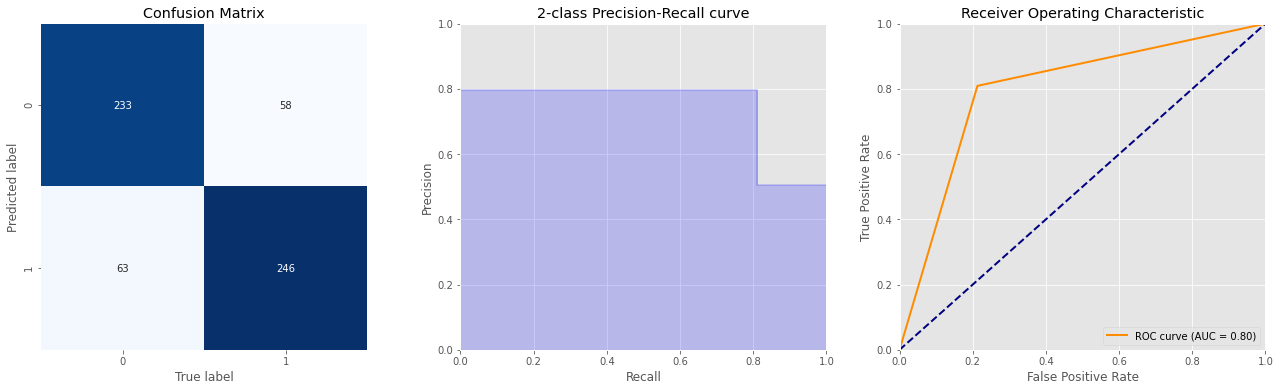

(0.7983333333333333,
 0.7961165048543689,
 0.8092105263157895,
 0.7981863442389757)

In [108]:
show_summary_report(y_test, predictions)

## Repeat using TF-IDF
TF-IDF = Term Frequency - Inverse Document Frequency

In [114]:
# create a matrix of word counts from the text
# use TF-IDF
tfidf = TfidfVectorizer()
# do the actual counting
A = tfidf.fit_transform(X_train, y_train)

# train the classifier with the training data
classifier.fit(A.toarray(), y_train)

# do the transformation for the test data
# NOTE: use `transform()` instead of `fit_transform()`
B = tfidf.transform(X_test)

# make predictions based on the test data
predictions_tfidf = classifier.predict(B.toarray())
matrix_tfidf = confusion_matrix(y_test, predictions_tfidf)


# check the accuracy
print('Accuracy: %.4f' % accuracy_score(y_test, predictions_tfidf))

Accuracy: 0.8017


Accuracy : 0.8017 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8013 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.8092 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8016                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


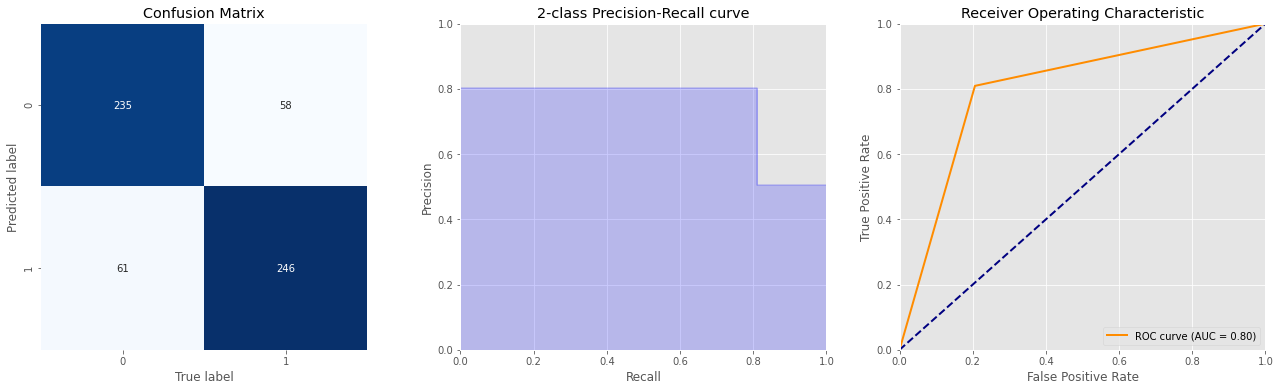

(0.8016666666666666,
 0.8013029315960912,
 0.8092105263157895,
 0.8015647226173541)

In [131]:
show_summary_report(y_test, predictions_tfidf)

## Repeating it all for comparision
Repeating the whole lot in one big block

Find 'Accuracy', 'Precision', 'Recall', 'ROC_AUC' using CountVectorizer and TfidfVectorizer and keep the result in a dataframe.

In [136]:
tfidf_TP = matrix_tfidf[1,1]
tfidf_TN = matrix_tfidf[0,0]
tfidf_FN = matrix_tfidf[1,0]
tfidf_FP = matrix_tfidf[0,1]

bow_TP = matrix_bow[1,1]
bow_TN = matrix_bow[0,0]
bow_FP = matrix_bow[0,1]
bow_FN = matrix_bow[1,0]

metrics = {
    'Accuracy': [accuracy_score(y_test, predictions_bow), accuracy_score(y_test, predictions_tfidf)],
    'Precision': [(bow_TP / (bow_TP + bow_FP)), (tfidf_TP/(tfidf_TP + tfidf_FP))],
    'Recall': [(bow_TP / (bow_TP + bow_FN)), (tfidf_TP/(tfidf_TP + tfidf_FN))],
    'ROC AUC': [roc_auc_score(y_test, predictions_bow), roc_auc_score(y_test,predictions_tfidf)]
    }

metrics_df = pd.DataFrame(metrics,index=['Bag of Words','TFIDF'])
metrics_df

,Accuracy,Precision,Recall,ROC AUC
Bag of Words,0.798333,0.796117,0.809211,0.798186
TFIDF,0.801667,0.801303,0.809211,0.801565




---



---



> > > > > > > > > © 2021 Institute of Data


---



---



